In [1]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import astropy.constants as constants
from astropy.stats import mad_std
import astropy.units as u

import pandas as pd

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from jas1101finalproject import GlobularCluster
from jas1101finalproject import plot
from jas1101finalproject.plot import LogNorm, AsinhNorm
from jas1101finalproject.utils import profile_binning, clip_quantile_nd
from jas1101finalproject.cluster import DBSCAN_Clustering

from jas1101finalproject.fit import sigmar_2

from jas1101finalproject.plot import colorbar_non_mappable

%load_ext autoreload
%autoreload 2

In [3]:
gc_name = "NGC_104_47Tuc"

GC = GlobularCluster.from_name(gc_name)
GC.table_full[:10]

x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm,member_prob_GMM,member_prob_DB
deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,,,deg,mas / yr,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
-0.1977684,-0.5888955,4.437221,-3.046831,2.568937,2.304999,-0.4350196,20.7788,0.816515,0,0.0,0.621216749580056,5.382574601935583,0.0,0.0
-0.1322767,-0.5762618,-0.06046668,-1.399454,1.140334,1.009628,-0.3081436,20.19374,0.8388195,0,0.0,0.5912484989428134,1.4007596929902795,0.0,0.0
-0.1302095,-0.5841963,25.03454,2.431298,1.950605,1.598516,-0.1853718,20.80205,2.071041,0,0.0,0.5985313950194593,25.152324007463086,0.0,0.0
-0.1348291,-0.4223898,4.965001,-1.958991,0.4321207,0.2950536,-0.2759779,18.64288,0.9655228,1,0.9608296,0.4433869972730932,5.337497603566862,1.0,0.0
-0.1274993,-0.6036617,0.6542604,-0.6097682,0.1797256,0.1373819,-0.1256039,17.40447,1.302572,1,0.0,0.6169793509894638,0.8943567122459584,0.0,0.0
-0.1955425,-0.5675544,5.504682,-9.945943,0.7583949,0.6022504,-0.2220912,19.82244,0.9101028,1,0.0,0.6002956490477088,11.36764294303674,0.0,0.0
-0.1460269,-0.5634596,4.810706,-2.849002,0.4770243,0.3784877,-0.1997244,19.0192,0.9610672,1,0.9145111,0.5820743735604326,5.591037883473872,0.0,0.0
-0.2434435,-0.5949736,0.4228585,-1.417316,0.3190453,0.2436593,-0.2938729,18.47891,1.179855,1,0.0,0.6428517110416756,1.4790517079798968,0.0,0.0


In [6]:
GC.summary

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pmscale,pmscale_e,pm,sc
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,"kpc,kpc,kpc"
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
NGC_104_47Tuc,6.02363,-72.081,4.5,-17.2,0.2,12.2,40.0,5.237,-2.524,0.039,0.039,-0.002,23917.2,18.3,0.418,0.399,0.015,5.8134967962492246,"1.3768803520135557,0.14529010919422547,-4.281715927103217"


In [32]:
dmls: u.Quantity = u.dimensionless_unscaled  # shortcut



tab_DB = GC.table_full[GC.table_full['member_prob_DB']==1]
GC_DB = pd.DataFrame({'r':(tab_DB["r"] / GC.rc_ang).to_value(dmls),
                      'pm':(tab_DB["pm"] / GC.pmc_ang).to_value(dmls)})

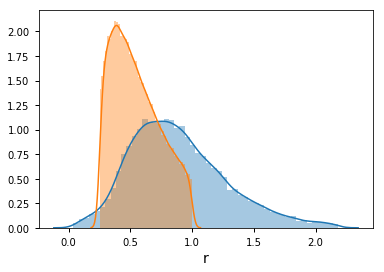

In [34]:
sns.distplot(GC.r)
sns.distplot(GC_DB.r)

Text(0, 0.5, 'PM')

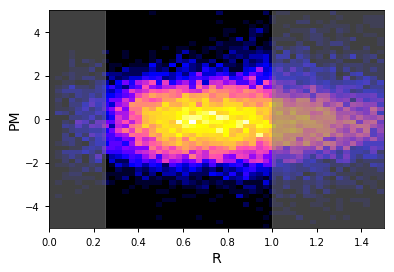

In [40]:
H, xb, yb, _ = plt.hist2d(GC.r, GC.pm-GC.pm.mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="gnuplot2")

plt.axvspan(0, 0.25, 0, color="gray", alpha=0.5)
plt.axvspan(1, 1.5, 0, color="gray", alpha=0.5)
plt.xlabel("R")  # normalized
plt.ylabel("PM") # normalized

Text(0, 0.5, 'PM')

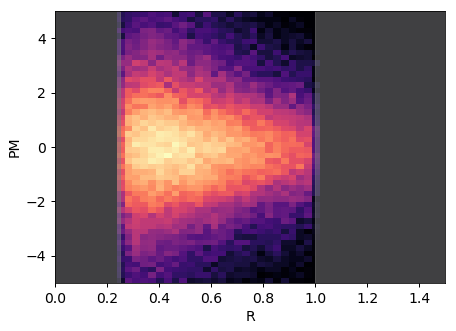

In [46]:
H, xb, yb, _ = plt.hist2d(GC_DB.r, GC_DB.pm-GC_DB.pm.mean(), bins=50, range=[[0,1.5],[-5,5]], norm=AsinhNorm(), cmap="magma")

plt.axvspan(0, 0.25, 0, color="gray", alpha=0.5)
plt.axvspan(1, 1.5, 0, color="gray", alpha=0.5)
plt.xlabel("R")  # normalized
plt.ylabel("PM") # normalized

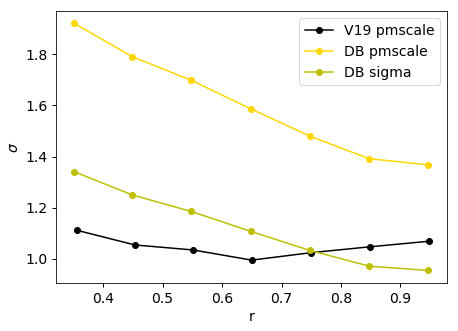

In [80]:
bins = np.linspace(0.3, 1, 8)
fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, bins=bins, label='V19 pmscale')
fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm, bins=bins, fig=fig, color='gold', label='DB pmscale')

scale = GC.pmc / GC['summary']['sigma']
fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm * scale, bins=bins, fig=fig, color='y', label='DB sigma')

plt.legend()

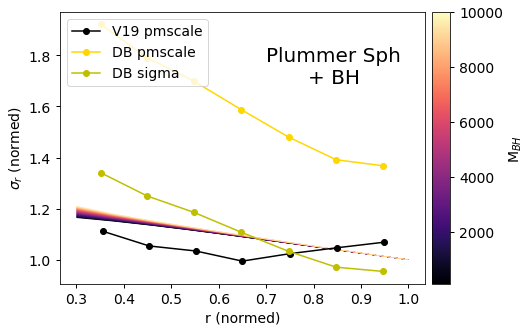

In [83]:
# parameter of GC
M_gc = 1e6
r_scale = 24
beta = 0.002 # ratio of M_BH

R = np.linspace(0.3, 1, 10)

fig = plot.plot_binned_sigma_profile(GC.r, GC.pm, bins=bins, label='V19 pmscale')
fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm, bins=bins, fig=fig, color='gold', label='DB pmscale')
fig = plot.plot_binned_sigma_profile(GC_DB.r, GC_DB.pm * scale, bins=bins, fig=fig, color='y', label='DB sigma')
plt.legend(loc=2)

(fig, ax) = plot.plot_model_sigma_profile(R, M_gc, r_scale, beta, N_mod=25, fig=fig)

### Read all GCs

In [25]:
import os
gc_names = [fname.split('.')[0] for fname in os.listdir(os.path.join(drct, 'gcs')) if fname.endswith('ecsv')]

GCs = [GlobularCluster.from_directory(name, drct) for name in gc_names]

In [26]:
r_all = np.concatenate([gc.r for gc in GCs if len(gc.table)>100])
pm_all = np.concatenate([gc.pm - gc.pm.mean() for gc in GCs if len(gc.table)>100])
print(r_all.shape)

(170871,)


Text(0.5,0,'R (normed)')

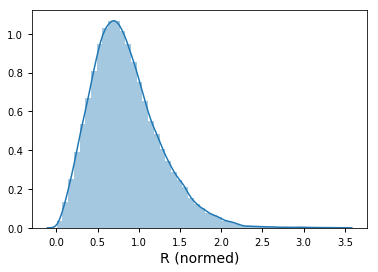

In [27]:
sns.distplot(r_all)
plt.xlabel("R (normed)")

Text(0.5,0,'PM (normed)')

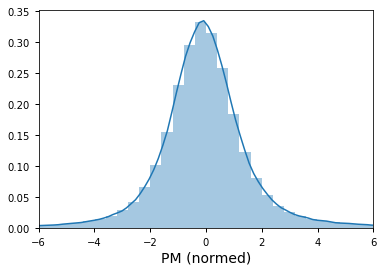

In [28]:
sns.distplot(pm_all[abs(pm_all)<10])
plt.xlim(-6,6)
plt.xlabel("PM (normed)")

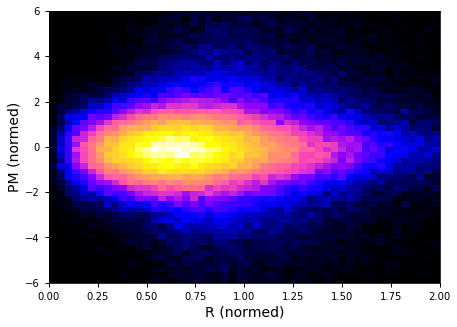

In [29]:
# display r-pm hist2d
plt.figure(figsize=(7,5))
H, xb, yb, _ = plt.hist2d(r_all, pm_all, bins=50, range=[[0,2],[-6,6]], norm=AsinhNorm(), cmap="gnuplot2")

plt.xlabel("R (normed)") # normalized
plt.ylabel("PM (normed)") # normalized
plt.show()

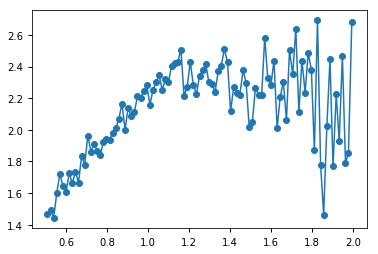

In [30]:
bins=np.linspace(0.5, 2, 100)
r_rbin, z_rbin, z_bins = profile_binning(r_all, pm_all, bins=bins, plot=False)

plt.plot(r_rbin, [np.std(z_bins[i]['pm']) for i in range(len(z_bins))],'o-')